In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import time

# Data

In [2]:
# Medical Insurance Cost dataset from https://www.kaggle.com/mirichoi0218/insurance
insurance = pd.read_csv('~/Desktop/Data_Science/insurance.csv')

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
insurance.shape

(1338, 7)

## Features

### Age

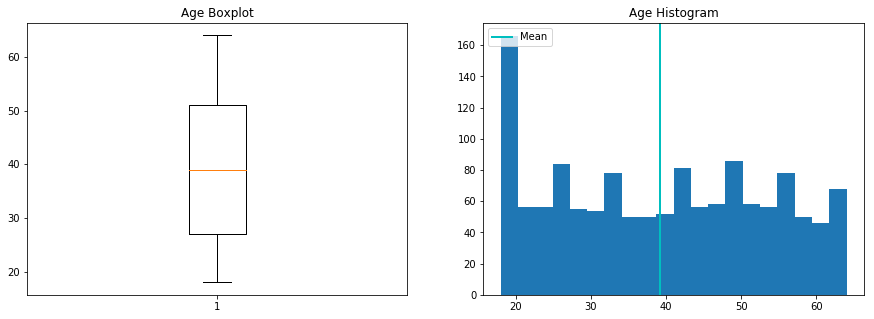

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['age'].dropna(how = 'any'))
plt.title('Age Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['age'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['age'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Age Histogram')

plt.show()

Ages range from 18 to 64 - adults before medicare age.  The average age is 39, which is below the mid-point of the age range, mostly due the greatest number of records for those under age 20.

### Sex/Gender

male      676
female    662
Name: sex, dtype: int64


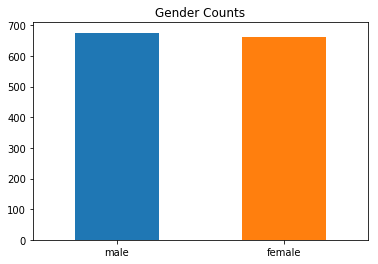

In [7]:
plt.title('Gender Counts')
pd.value_counts(insurance['sex']).plot.bar()
plt.xticks(rotation = 0)
print(insurance['sex'].value_counts())

Nearly equal number of male and female records, just 14 more male records than female.

In [8]:
#Convert to numeric
insurance['male_gender'] = 0
insurance.loc[insurance['sex'] == 'male', 'male_gender'] = 1

#Delete original 'smoker' variable
insurance = insurance.drop('sex', 1)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

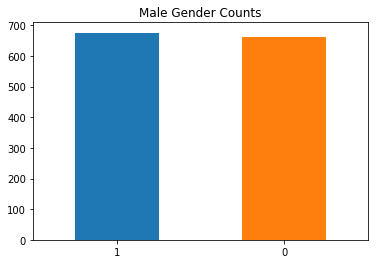

In [9]:
plt.title('Male Gender Counts')
pd.value_counts(insurance['male_gender']).plot.bar()
plt.xticks(rotation = 0)

### BMI

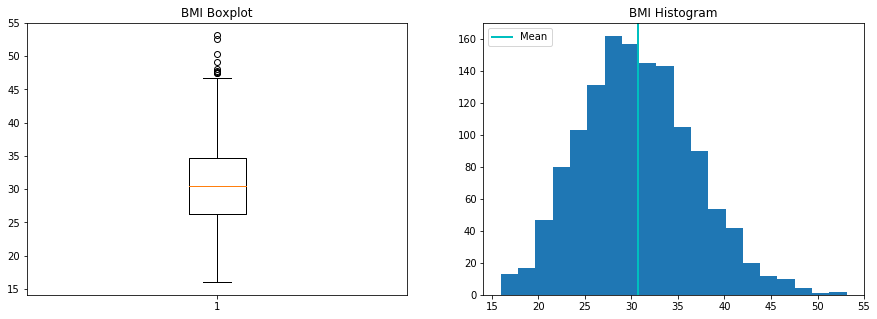

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['bmi'].dropna(how = 'any'))
plt.title('BMI Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['bmi'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['bmi'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('BMI Histogram')

plt.show()

Normal distribution of values, with a median of 31.7

According to Wikipedia, the body mass index (BMI) is a value derived from the weight and height of an individual. Commonly accepted BMI ranges are underweight: under 18.5 kg/m2, normal weight: 18.5 to 25, overweight: 25 to 30, obese: over 30.  This means that most of these records are for individuals considered to have an unhealthy weight for their height.

### Children

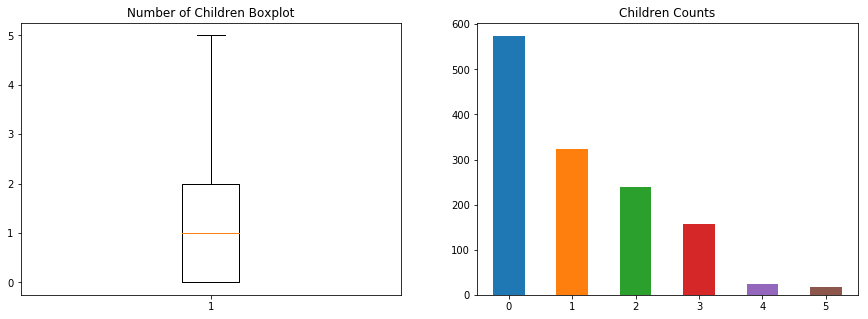

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['children'].dropna(how = 'any'))
plt.title('Number of Children Boxplot')

plt.subplot(1, 2, 2)
plt.title('Children Counts')
pd.value_counts(insurance['children']).plot.bar()
plt.xticks(rotation = 0)

plt.show()

More records are for individuals with children than not, but the most frequent number of children is none.<br>
Let's make a new boolean feature that captures whether the record is for a parent.

In [12]:
#create boolean parent feature
insurance['parent'] = 0
insurance.loc[insurance['children'] > 0, 'parent'] = 1

(array([0, 1]), <a list of 2 Text xticklabel objects>)

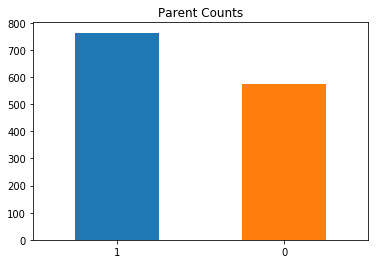

In [13]:
plt.title('Parent Counts')
pd.value_counts(insurance['parent']).plot.bar()
plt.xticks(rotation = 0)

### Smoker

yes     274
no     1064
dtype: int64


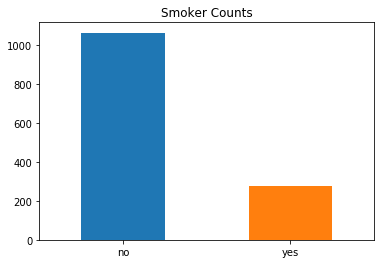

In [14]:
plt.title('Smoker Counts')
pd.value_counts(insurance['smoker']).plot.bar()
plt.xticks(rotation = 0)
print(pd.value_counts(insurance['smoker'].values, sort=False))

There are more non-smokers (1064) than smokers (274)

In [15]:
#Convert to numeric
insurance['smoke'] = 0
insurance.loc[insurance['smoker'] == 'yes', 'smoke'] = 1

#Delete original 'smoker' variable
insurance = insurance.drop('smoker', 1)

0    1064
1     274
dtype: int64


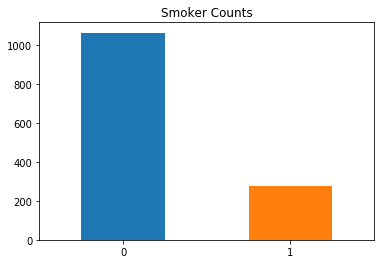

In [16]:
plt.title('Smoker Counts')
pd.value_counts(insurance['smoke']).plot.bar()
plt.xticks(rotation = 0)
print(pd.value_counts(insurance['smoke'].values, sort=False))

### Region

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

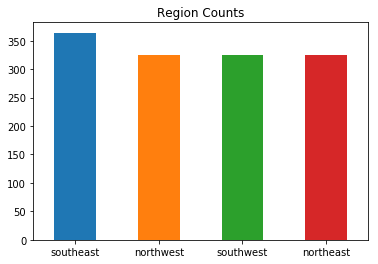

In [17]:
plt.title('Region Counts')
pd.value_counts(insurance['region']).plot.bar()
plt.xticks(rotation = 0)

There are an equal number of records from the Northwest, Northeast and Southwest, and slightly more records from the Southeast.

In [18]:
#Convert to numeric
insurance['south'] = 0
insurance.loc[insurance['region'].str.contains("south", na=False), 'south'] = 1
insurance['east'] = 0
insurance.loc[insurance['region'].str.contains("east", na=False), 'east'] = 1

#Delete original 'smoker' variable
insurance = insurance.drop('region', 1)

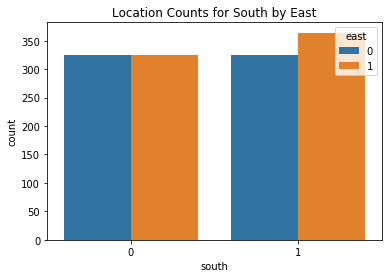

In [19]:
import seaborn as sns
plt.title('Location Counts for South by East')
sns.countplot(x='south', hue='east', data=insurance)

### Charges

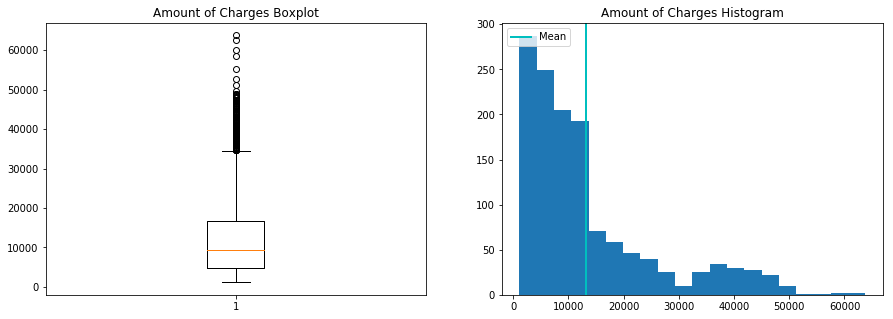

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['charges'].dropna(how = 'any'))
plt.title('Amount of Charges Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['charges'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['charges'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Amount of Charges Histogram')

plt.show()

Heavily left-skewed data with a mean of $13,270.  Outliers range up to $63,770.

Let's try a log of the Charges variable to get a more normally distributed feature.

In [21]:
#create feature by taking log if insurance variable
insurance['charges_log'] = np.log(insurance['charges'])

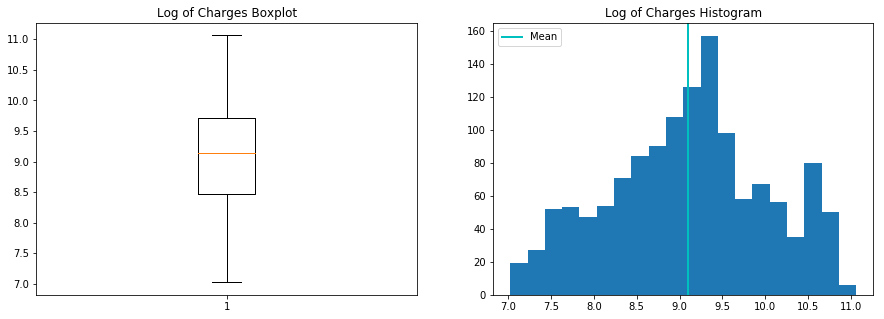

In [22]:
#visualize new feature
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['charges_log'].dropna(how = 'any'))
plt.title('Log of Charges Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['charges_log'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['charges_log'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Log of Charges Histogram')

plt.show()

That looks like a more useful feature - no more outliers and the distribution is much closer to normal

### Recap Data

In [23]:
insurance.head()

,age,bmi,children,charges,male_gender,parent,smoke,south,east,charges_log
0,19,27.900,0,16884.92400,0,0,1,1,0,9.734176
1,18,33.770,1,1725.55230,1,1,0,1,1,7.453302
2,28,33.000,3,4449.46200,1,1,0,1,1,8.400538
3,33,22.705,0,21984.47061,1,0,0,0,0,9.998092
4,32,28.880,0,3866.85520,1,0,0,0,0,8.260197


In [24]:
insurance.describe()

,age,bmi,children,charges,male_gender,parent,smoke,south,east,charges_log
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.505232,0.571001,0.204783,0.514948,0.514200,9.098659
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.495118,0.403694,0.499963,0.499985,0.919527
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000,7.022756
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000,0.000000,8.463853
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,1.000000,0.000000,1.000000,1.000000,9.146552
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,1.000000,0.000000,1.000000,1.000000,9.719558
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000,11.063045


In [25]:
insurance.shape

(1338, 10)

Let's check for correlation between features to see if any might be unnecessary

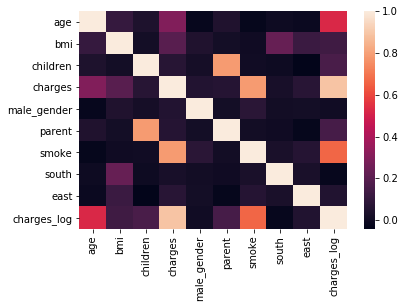

In [26]:
sns.heatmap(insurance.corr())

In [27]:
correlation_matrix = insurance.corr()
display(correlation_matrix)

,age,bmi,children,charges,male_gender,parent,smoke,south,east,charges_log
age,1.000000,0.109272,0.042469,0.299008,-0.020856,0.047075,-0.025019,-0.001772,-0.008245,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.046371,0.016082,0.003750,0.235113,0.122011,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.017163,0.787569,0.007673,-0.001735,-0.040086,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.057292,0.064760,0.787251,0.028799,0.071314,0.892964
male_gender,-0.020856,0.046371,0.017163,0.057292,1.000000,0.015111,0.076185,0.011651,0.013162,0.005632
parent,0.047075,0.016082,0.787569,0.064760,0.015111,1.000000,0.009526,0.001752,-0.026736,0.154165
smoke,-0.025019,0.003750,0.007673,0.787251,0.076185,0.009526,1.000000,0.029292,0.063400,0.665506
south,-0.001772,0.235113,-0.001735,0.028799,0.011651,0.001752,0.029292,1.000000,0.029071,-0.021662
east,-0.008245,0.122011,-0.040086,0.071314,0.013162,-0.026736,0.063400,0.029071,1.000000,0.051015
charges_log,0.527834,0.132669,0.161336,0.892964,0.005632,0.154165,0.665506,-0.021662,0.051015,1.000000


We see the correlation between our original variables (children and charges) and the new features we made from them (parent and charges_log).  Charges shows some noticeable correlation to smoke, and charges_log shows some correlation to age, but smoke and age are not closely correlated.

Also of note, gender isn't very strongly correlated to any of our features.

## Use a Decision Tree to predict gender

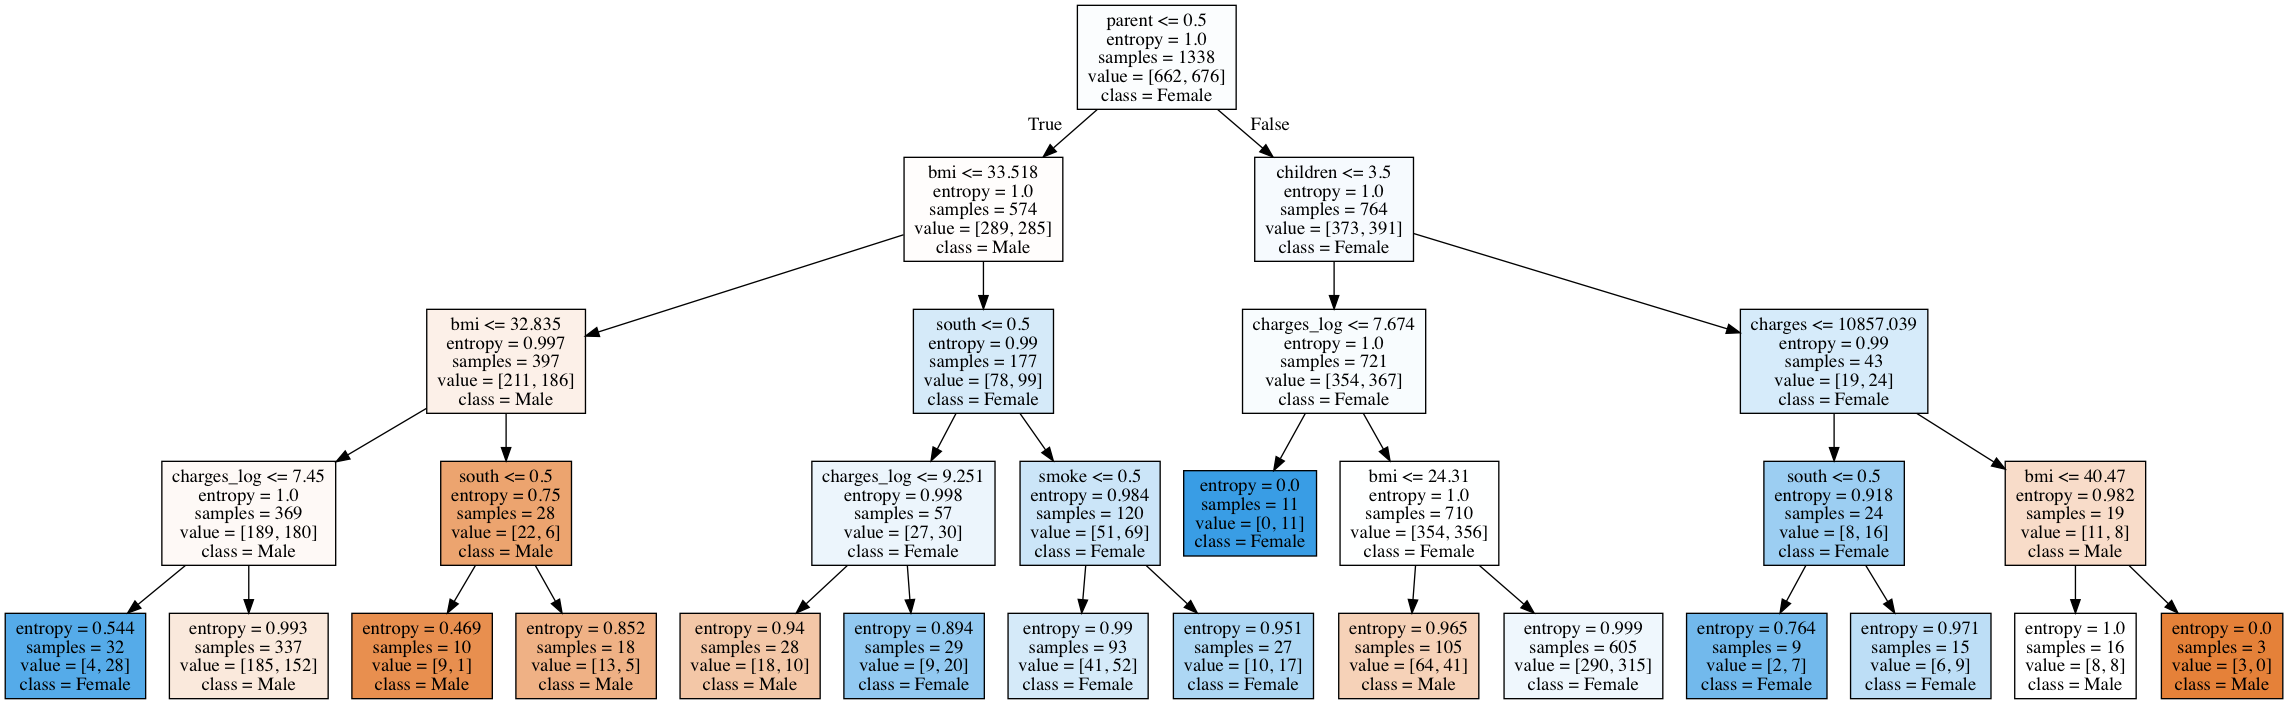

In [28]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)

X = insurance.drop('male_gender', 1)
Y = insurance['male_gender']

decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Male', 'Female'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [29]:
score = cross_val_score(decision_tree, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation range: %0.2f to %0.2f" % (score.min(), score.max()))
print("\nCross Validation Average: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Validation Scores:
 [0.52592593 0.4962963  0.48507463 0.54477612 0.55223881 0.45522388
 0.58646617 0.54135338 0.48120301 0.4962406 ]

Cross Validation range: 0.46 to 0.59

Cross Validation Average: 0.52 (+/- 0.08)


Right off the bat, we have 0.52 average of Cross Validation scores.  That's only slightly better than the 50.5% baseline.
Let's try tuning the decision tree's max_features and max_depth settings.

In [30]:
#Test max_features

def tree_feature_fit(features):
    dt = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=features,
        max_depth=4,
        random_state = 1337
    )
    score = cross_val_score(dt, X, Y, cv=10)
    return print("%d Max Features has a Cross Validation mean of: %0.2f (+/- %0.2f)" % (features, score.mean(), score.std() * 2))
    
for i in range(9):
    tree_feature_fit(i + 1)

1 Max Features has a Cross Validation mean of: 0.52 (+/- 0.08)
2 Max Features has a Cross Validation mean of: 0.52 (+/- 0.05)
3 Max Features has a Cross Validation mean of: 0.54 (+/- 0.07)
4 Max Features has a Cross Validation mean of: 0.56 (+/- 0.06)
5 Max Features has a Cross Validation mean of: 0.56 (+/- 0.07)
6 Max Features has a Cross Validation mean of: 0.55 (+/- 0.06)
7 Max Features has a Cross Validation mean of: 0.55 (+/- 0.06)
8 Max Features has a Cross Validation mean of: 0.56 (+/- 0.06)
9 Max Features has a Cross Validation mean of: 0.56 (+/- 0.06)


The best mean accuracy is with 4, 8 and 9 max features - let's stick with 4.

In [31]:
#Test max_depth, use max_features=7 due to best result above

def tree_depth_fit(depth):
    dt = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=4,
        max_depth=depth,
        random_state = 1337
    )
    score = cross_val_score(dt, X, Y, cv=10)
    return print("Depth of %d has a Cross Validation mean of: %0.2f (+/- %0.2f)" % (depth, score.mean(), score.std() * 2))
    
for i in range(50):
    tree_depth_fit(i + 1)

Depth of 1 has a Cross Validation mean of: 0.51 (+/- 0.02)
Depth of 2 has a Cross Validation mean of: 0.54 (+/- 0.06)
Depth of 3 has a Cross Validation mean of: 0.56 (+/- 0.08)
Depth of 4 has a Cross Validation mean of: 0.56 (+/- 0.06)
Depth of 5 has a Cross Validation mean of: 0.56 (+/- 0.07)
Depth of 6 has a Cross Validation mean of: 0.55 (+/- 0.07)
Depth of 7 has a Cross Validation mean of: 0.56 (+/- 0.08)
Depth of 8 has a Cross Validation mean of: 0.55 (+/- 0.08)
Depth of 9 has a Cross Validation mean of: 0.56 (+/- 0.09)
Depth of 10 has a Cross Validation mean of: 0.55 (+/- 0.07)
Depth of 11 has a Cross Validation mean of: 0.56 (+/- 0.07)
Depth of 12 has a Cross Validation mean of: 0.55 (+/- 0.07)
Depth of 13 has a Cross Validation mean of: 0.55 (+/- 0.08)
Depth of 14 has a Cross Validation mean of: 0.57 (+/- 0.06)
Depth of 15 has a Cross Validation mean of: 0.57 (+/- 0.06)
Depth of 16 has a Cross Validation mean of: 0.57 (+/- 0.07)
Depth of 17 has a Cross Validation mean of: 0.55 

The best mean accuracy is a max depth of 37 and 38.  Let's stick with 37

In [32]:
dt = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=4,
        max_depth=37,
        random_state = 1337
    )

score = cross_val_score(dt, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Validation Scores:
 [0.63703704 0.62222222 0.63432836 0.6119403  0.58208955 0.59701493
 0.60150376 0.60150376 0.54135338 0.59398496]

Cross Validation mean of: 0.60 (+/- 0.05)


Now let's test our variaables

In [33]:
# recursive feature elimination

from sklearn.feature_selection import RFE
selector = RFE(dt)
selector = selector.fit(X, Y)

rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')

,Features,Ranking
0,age,1
1,bmi,1
3,charges,1
8,charges_log,1
2,children,2
7,east,3
4,parent,4
6,south,5
5,smoke,6


In [34]:
# drop least significant feature

rfe_X = X.drop('smoke', 1)

score = cross_val_score(dt, rfe_X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Validation Scores:
 [0.51111111 0.57037037 0.55970149 0.58955224 0.59701493 0.6119403
 0.60902256 0.54135338 0.59398496 0.5112782 ]

Cross Validation mean of: 0.57 (+/- 0.07)


By removing our least significant feature, we've noticeable reduced our predictive power and done nothing to correct overfitting, so let's keep all of our features andtest for time.  Let's retest the max_depth setting and see if we can do anything about the overfitting.

In [38]:
# retest and time with all features

start_time = time.time()

score = cross_val_score(dt, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation range: %0.2f to %0.2f" % (score.min(), score.max()))
print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("\n--- %s seconds ---" % (time.time() - start_time))

Cross Validation Scores:
 [0.63703704 0.62222222 0.63432836 0.6119403  0.58208955 0.59701493
 0.60150376 0.60150376 0.54135338 0.59398496]

Cross Validation range: 0.54 to 0.64

Cross Validation mean of: 0.60 (+/- 0.05)

--- 0.1157839298248291 seconds ---


Our best result using a Decision Tree model is a Cross Validation mean of 0.60 (+/- 0.05) and a range of 0.10, from 0.54 to 0.64.  The execution takes about 0.12 seconds

## Use a Random Forest to predict gender

In [45]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
X = insurance.drop('male_gender', 1)
Y = insurance['male_gender']
X = X.dropna(axis=1)

score = cross_val_score(rfc, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation Average: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Validation Scores:
 [0.60740741 0.59259259 0.53731343 0.6641791  0.59701493 0.48507463
 0.64661654 0.61654135 0.56390977 0.60150376]

Cross Validation Average: 0.59 (+/- 0.10)


A first attempt at Random Forest shows an average Cross Validation of 0.59 (+/- 11).  The range of results is greater at 0.16 (from 0.49 to 0.65), <br>
Let's try recursive feature selection with this model, just in case it shows anything different from from the decision tree test.

In [47]:
# recursive feature elimination

selector = RFE(rfc)
selector = selector.fit(X, Y)

rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')

,Features,Ranking
0,age,1
1,bmi,1
3,charges,1
8,charges_log,1
2,children,2
7,east,3
6,south,4
4,parent,5
5,smoke,6


No change from the prior test, our 'smoke' variable is still least impactful, so let see what happens when we remove it.

In [48]:
# drop least significant feature and test accuracy

X = X.drop('smoke', 1)

score = cross_val_score(rfc, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Validation Scores:
 [0.54074074 0.5037037  0.58955224 0.60447761 0.58955224 0.57462687
 0.58646617 0.5112782  0.65413534 0.58646617]

Cross Validation mean of: 0.57 (+/- 0.09)


As with our Decision Tree model, the Random Forest tests lose predictive power when we drop a feature.  Let's test our original RF model again and test for time to execute.

In [58]:
start_time = time.time()

score = cross_val_score(rfc, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation range: %0.2f to %0.2f" % (score.min(), score.max()))
print("\nCross Validation Average: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("\n--- %s seconds ---" % (time.time() - start_time))

Cross Validation Scores:
 [0.57037037 0.54074074 0.59701493 0.6641791  0.57462687 0.49253731
 0.62406015 0.59398496 0.60150376 0.61654135]

Cross Validation range: 0.49 to 0.66

Cross Validation Average: 0.59 (+/- 0.09)

--- 0.3386709690093994 seconds ---


The best result with Random Forest is a Cross Validation Average of 0.59 (+/- 0.09), not quite as good as the tuned Decision Tree result.  And, the processing speed is more than double, at about 0.34 seconds.
There is also less consistency with Random Forest as there is less potential for clalibration, with fewer inputs to the model (like max_features and max_depth)

### Tuning Random Forest

In [141]:
def forest_depth_fit(depth):
    rfc = ensemble.RandomForestClassifier(
        max_depth=depth
    )
    score = cross_val_score(rfc, X, Y, cv=10)
    return print("Depth of %d has a Cross Validation mean of: %0.2f (+/- %0.2f)" % (depth, score.mean(), score.std() * 2))
    
for i in range(50):
    forest_depth_fit(i + 1)

Depth of 1 has a Cross Validation mean of: 0.52 (+/- 0.08)
Depth of 2 has a Cross Validation mean of: 0.53 (+/- 0.05)
Depth of 3 has a Cross Validation mean of: 0.54 (+/- 0.08)
Depth of 4 has a Cross Validation mean of: 0.55 (+/- 0.06)
Depth of 5 has a Cross Validation mean of: 0.55 (+/- 0.08)
Depth of 6 has a Cross Validation mean of: 0.55 (+/- 0.06)
Depth of 7 has a Cross Validation mean of: 0.56 (+/- 0.06)
Depth of 8 has a Cross Validation mean of: 0.56 (+/- 0.08)
Depth of 9 has a Cross Validation mean of: 0.57 (+/- 0.05)
Depth of 10 has a Cross Validation mean of: 0.57 (+/- 0.06)
Depth of 11 has a Cross Validation mean of: 0.59 (+/- 0.10)
Depth of 12 has a Cross Validation mean of: 0.57 (+/- 0.08)
Depth of 13 has a Cross Validation mean of: 0.59 (+/- 0.11)
Depth of 14 has a Cross Validation mean of: 0.58 (+/- 0.08)
Depth of 15 has a Cross Validation mean of: 0.56 (+/- 0.06)
Depth of 16 has a Cross Validation mean of: 0.58 (+/- 0.05)
Depth of 17 has a Cross Validation mean of: 0.57 

   feature_number      mean       std
0               1  0.557442  0.037599
1               2  0.582899  0.032419
2               3  0.608430  0.036244
3               4  0.621117  0.032518
4               5  0.600900  0.030855
5               6  0.624782  0.032118
6               7  0.582777  0.055400


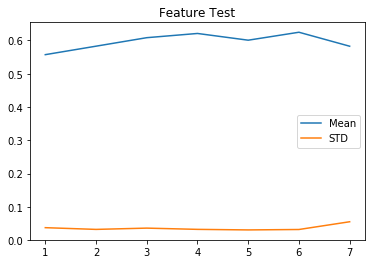

In [140]:
#Test max_features

tune_results = pd.DataFrame()

def forest_feature_fit(feature):
    rfc = ensemble.RandomForestClassifier(
        max_features=feature
    )
    score = cross_val_score(rfc, X, Y, cv=10)
    data = pd.DataFrame({"feature_number": [feature], "mean": [score.mean()], "std": [score.std()]})
    return data
                                       
appended_data = []
for i in range(7):
    result = forest_feature_fit(i + 1)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.head(7))

plt.plot(tune_results['feature_number'], tune_results['mean'], label="Mean")
plt.plot(tune_results['feature_number'], tune_results['std'], label="STD")
plt.legend(loc='best') 
plt.title('Feature Test')
plt.show()

   depth_number      mean       std
0             1  0.514118  0.038574
1             2  0.523764  0.061126
2             3  0.541731  0.043476
3             4  0.559581  0.049919
4             5  0.537309  0.045857


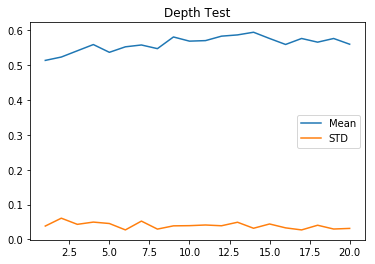

In [146]:
#Test max_features

tune_results = pd.DataFrame()

def forest_depth_fit(depth):
    rfc = ensemble.RandomForestClassifier(
        max_depth=depth
    )
    score = cross_val_score(rfc, X, Y, cv=10)
    data = pd.DataFrame({"depth_number": [depth], "mean": [score.mean()], "std": [score.std()]})
    return data
                                       
appended_data = []
for i in range(20):
    result = forest_depth_fit(i + 1)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.head())

plt.plot(tune_results['depth_number'], tune_results['mean'], label="Mean")
plt.plot(tune_results['depth_number'], tune_results['std'], label="STD")
plt.legend(loc='best') 
plt.title('Depth Test')
plt.show()